In [1]:
# Familiar imports
import numpy as np
import pandas as pd
import random
import os
import time
from pathlib import Path
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from scipy.optimize import minimize

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 500
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train['lgb_pred'] = np.load("../input/tps-aug-2021-lgb/lgb_oof.npy")
test['lgb_pred'] = np.load("../input/tps-aug-2021-lgb/lgb_pred.npy")

train['xgb_pred'] = np.load("../input/tps-aug-2021-xgb/xgb_oof.npy")
test['xgb_pred'] = np.load("../input/tps-aug-2021-xgb/xgb_pred.npy")

train['xgb2_pred'] = np.load("../input/tps-aug-2021-xgb-pseudo2-pred/3xgb_oof.npy")+np.load("../input/tps-aug-2021-xgb-pseudo2-pred/4xgb_oof.npy")
test['xgb2_pred'] = np.load("../input/tps-aug-2021-xgb-pseudo2-pred/3xgb_pred.npy")+np.load("../input/tps-aug-2021-xgb-pseudo2-pred/4xgb_pred.npy")

train['ctb2_pred'] = np.load("../input/tps-aug-2021-catb-pseudo2/ctb_oof.npy")
test['ctb2_pred'] = np.load("../input/tps-aug-2021-catb-pseudo2/ctb_pred.npy")

# Preprocessing

In [6]:
scale_features = [col for col in test.columns if 'f' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])

In [7]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Pseudo Label

In [8]:
pseudo = pd.read_csv("../input/blending-tool-tps-aug-2021/blend.csv/0.part")[target]
test_pseudo = pd.concat([test, pseudo], axis=1)
all_pseudo = pd.concat([train, test_pseudo]).reset_index(drop=True)

In [9]:
useful_features = scale_features + ['lgb_pred', 'xgb_pred','xgb2_pred','ctb2_pred']

# RF

In [10]:
rr_params  = {
                  'n_estimators':N_ESTIMATORS,
                    #'objective': 'regression',
              'criterion':'mse',
                  #'metric':'rmse',
              'n_jobs':-1,
              'bootstrap':True,
    
            'max_depth': 6,
            'max_features': 0.9244341048225673, 
            'max_samples': 0.4938470905166652,
            'ccp_alpha': 2.8153101495289973e-06

                }

In [11]:
rr_oof = np.zeros(train.shape[0])
rr_pred = np.zeros(test.shape[0])
rr_importances = pd.DataFrame()


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo[useful_features], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    
    if fold >6:
        
        oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
        preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])

        X_train, y_train = all_pseudo[useful_features].iloc[trn_idx], all_pseudo[target].iloc[trn_idx]
        #X_train = apply_noise_row(X_train)

        X_valid, y_valid = all_pseudo[useful_features].iloc[oof_idx], all_pseudo[target].iloc[oof_idx]
        X_test = all_pseudo[useful_features].iloc[preds_idx]

        # rr
        start = time.time()

        for inseed in seed_list:
            rr_params['random_state'] = inseed

            model = RandomForestRegressor(**rr_params, verbose=0)
            model.fit(
                X_train, 
                y_train,

            )

            with open(f"rr_model{fold}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = useful_features
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            rr_importances = rr_importances.append(fi_tmp)

            rr_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
            rr_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)

        elapsed = time.time() - start
        rmse = mean_squared_error(y_valid, rr_oof[oof_idx], squared=False)
        print(f"fold {fold} - rr rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

        
print(f"oof rr_rmse = {mean_squared_error(train[target], rr_oof, squared=False)}")

np.save("rr_oof.npy", rr_oof)
np.save("rr_pred.npy", rr_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
===== fold 4 =====
===== fold 5 =====
===== fold 6 =====
===== fold 7 =====
fold 7 - rr rmse: 7.873682, elapsed time: 8248.14sec

===== fold 8 =====
fold 8 - rr rmse: 7.861420, elapsed time: 8107.37sec

===== fold 9 =====
fold 9 - rr rmse: 7.837854, elapsed time: 7988.42sec

oof rr_rmse = 9.731647541361129


# OOF predictions

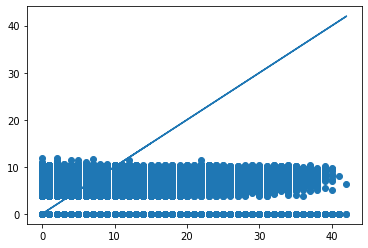

In [12]:
plt.plot(train[target], train[target])
plt.scatter(train[target], rr_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

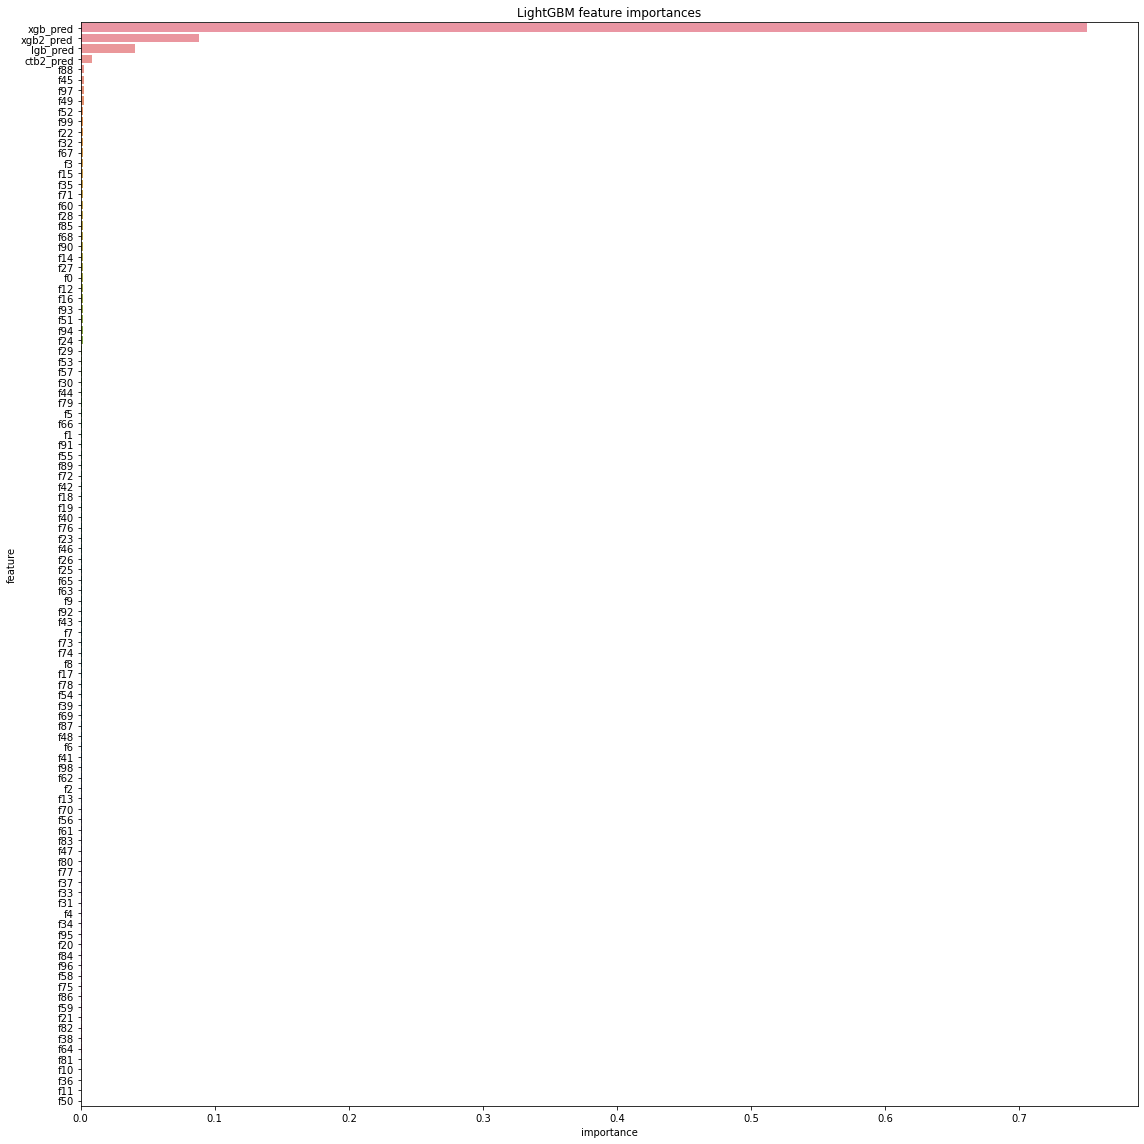

In [13]:
order = list(rr_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=rr_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [14]:
submission[target] = rr_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,0.0
1,250001,0.0
2,250002,0.0
3,250003,0.0
4,250004,0.0
...,...,...
149995,399995,0.0
149996,399996,0.0
149997,399997,0.0
149998,399998,0.0
